# GTSRB CNN training

For the CNN in the GTSRB dataset, many different configurations were tried, with varying number of layers, CNN filters, the filter kernel size, and dropout. Since the signs typically come from a track of images, and the images are eventually resized, the biggest improvement to the model was having a fairly large dropout percentage. Going from no dropout made the model go from ~90% accuracy to ~97% accuracy. The final net configuration was:
 - Image Size: 40x40 pixels
 - CNN layers: 3
 - CNN filters: 256 each
 - kernel size: 5
 - Pooling size: (2,2)
 - dense layers: 1
 - dense layer size: 128
 - drop out percentage: 40%
 - batch size: 512


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
import seaborn as sns
import os
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
import tensorflow as tf
import glob
import category_encoders as ce
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV

Image sizes of 20-100 were tried, with around 40 performing the best

In [2]:
image_size = 40

Method for calculating IoU

In [12]:
#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

## Load the datasets

In [6]:
#folders = os.listdir('../GTSRB/')
train_images = []
train_files = glob.glob('../GTSRB/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/0*/*')  # iterate through all subfolders
train_labels = []
track_labels = []
first_file = 0
for file in train_files:
    if '.ppm' in file:
        image = cv2.imread(file)
        image = cv2.resize(image, (image_size, image_size))
        # read in the files and downscale to 25x25
        if first_file == 0:
            print(file)
            first_file = 1

        train_labels.append(int(file.split("\\")[1]))
        track_labels.append(int(file.split("\\")[2].split("_")[0]))
        train_images.append(image)
print(len(train_images))

./GTSRB/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images\00000\00000_00000.ppm
39209


In [8]:
#folders = os.listdir('../GTSRB/')
test_images = []
test_files = glob.glob('../GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/*')  # iterate through all subfolders
test_labels = []
track_labels = []
first_file = 0
for file in test_files:
    if '.ppm' in file:
        image = cv2.imread(file)
        image = cv2.resize(image, (image_size, image_size))
        # read in the files and downscale to 25x25
        if first_file == 0:
            print(file)
            first_file = 1
        test_images.append(image)
print(len(test_images))      

./GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images\00000.ppm
12630


## Make BG set

Use training images from GTSDB to make background images. Randomly choose images and select a random size box from it. Make sure it doesn't overlap with any sign bounding boxes

In [13]:
#folders = os.listdir('../GTSRB/')
big_images = []
big_labels = []
first_file = 0
for i in range(600):
    image_id = str(i).rjust(5,'0')
    image = cv2.imread(f'FullIJCNN2013/{image_id}.ppm')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, (image_size, image_size))
    big_images.append(image)
print(len(big_images))

600


In [ ]:
#Extract largest dimension for each image
size_list = []
for i in train_images:
    size_list.append(max(i.shape[0],i.shape[1]))

In [14]:
label_df = pd.read_csv(f'../FullIJCNN2013/gt.txt',names=['file','x1','y1','x2','y2','class'],delimiter = ';')

42

In [15]:
random.seed(42)
bg = []
count = 0
while len(bg) < 3000:
#     if count % 1000 == 0:
#         print(count, temp_df.shape[0],r,x,y,img)
#     count += 1
    r = random.sample(size_list,1)[0]//2
    x = random.randint(r+5,1354-r)
    y = random.randint(r+5,794-r)
    img = random.randint(0,599)
    image_id = str(img).rjust(5,'0')
    box1 = [x-r,y-r,x+r,y+r]
    temp_df = label_df[label_df['file'] == image_id+'.ppm']
    skipflag = 0
    for i in range(temp_df.shape[0]):
        box2 = [temp_df.iloc[i,1],temp_df.iloc[i,2],temp_df.iloc[i,3],temp_df.iloc[i,4]]
        if bb_intersection_over_union(box1,box2)>=0.:
            skipflag = 1
    if skipflag == 1:
        continue
    image = big_images[img]
    bg.append(image[box1[1]:box1[3] ,  box1[0]:box1[2] ])

In [17]:
for i in range(len(bg)):
    bg[i] = cv2.resize(bg[i], (image_size, image_size))

White isn't blank, it's Germany. They have many overcast white days. 

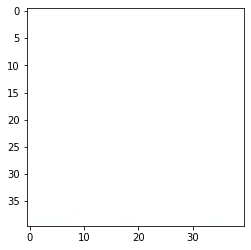

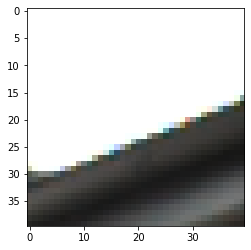

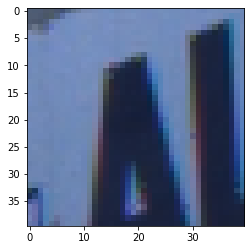

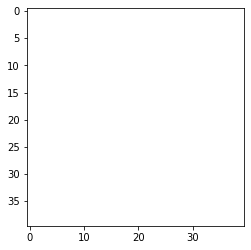

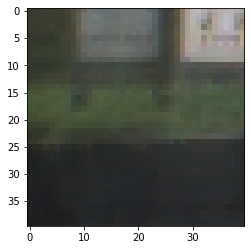

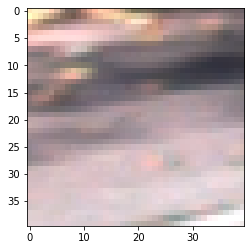

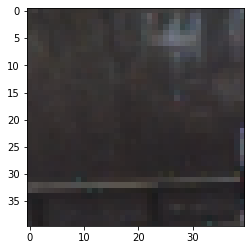

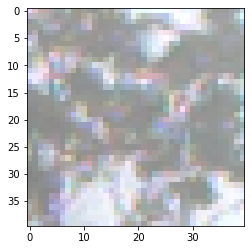

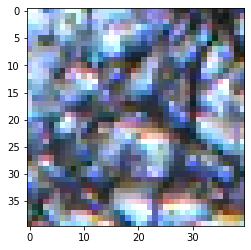

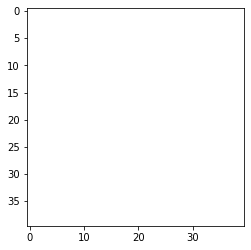

In [18]:
for i in range(10):
    plt.imshow(bg[i],)
    plt.show()

## Process sets

Standardize the images, add the background images. Extract labels, and prepare everything for training. 

In [19]:
train_images = train_images + bg[:2250]
test_images = test_images + bg[2250:]

In [26]:
train_images = [image/255 for image in train_images]
train_images = np.array(train_images)

In [27]:
test_images = [image/255 for image in test_images]
test_images = np.array(test_images)

In [20]:
train_labels = train_labels + [43 for i in range(2250)]

In [23]:
test_labels = pd.read_csv("./GTSRB/GTSRB_Final_TEST_GT/GT-final_test.csv",delimiter = ";")
test_labels.head()

In [28]:
y_train = pd.DataFrame(train_labels,columns=['label'])
encoder = ce.OneHotEncoder(cols=['label'], use_cat_names=True,
                        return_df=False)
print(y_train['label'].nunique())
y_train = encoder.fit_transform(y_train)
y_train

44


C:\Users\Scott\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

Setup the final activation for the CNN

In [ ]:
loss_func, act_func, out_layer = 'categorical_crossentropy', 'softmax', 44

In [29]:
test_labels = test_labels[['ClassId']].rename(columns={"ClassId":"label"})
dummy_df = pd.concat([pd.DataFrame([43], columns=['label']) for i in range(750)],
          ignore_index=True)
test_labels = pd.concat([test_labels,dummy_df],ignore_index=True)
test_labels

,label
0,16
1,1
2,38
3,33
4,11
...,...
13375,43
13376,43
13377,43
13378,43


In [30]:
y_test = encoder.transform(test_labels)
y_test 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

## Prepare the CNN

Used uniform filter sizes after trying different sizes, set the parameters here for easy view. Sets the number of CNN filters, their Kernel size, pooling, dense layers, batch size, and dropout. Standardize the output filename. 

In [32]:
n_filters = 256
kernel_s = 5
mp = 2
dense_l = 128
batch = 512
drop = 0.4
name_out = f'../models/{image_size}_{n_filters}_{kernel_s}_{mp}_{dense_l}_{drop}_3_{batch}_bg'
name_out

'./models/40_256_5_2_128_0.4_3_512_bg'

Instantiate the model. 

In [109]:
#Instantiate model
cnn = Sequential()

#convolution layers
cnn.add(Conv2D(filters = n_filters,       #number of filters to use
              kernel_size = (kernel_s,kernel_s),   #dimensions of the filters
              activation = 'relu',    #activation function
              input_shape = (image_size, image_size,3)))  #shape of image
cnn.add(MaxPooling2D(pool_size = (mp,mp))) 
cnn.add(Dropout(drop))
cnn.add(Conv2D(n_filters, kernel_size = (kernel_s,kernel_s), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (mp,mp)))
cnn.add(Dropout(drop))
cnn.add(Conv2D(n_filters, kernel_size = (kernel_s,kernel_s), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (mp,mp)))
cnn.add(Dropout(drop))
cnn.add(Flatten())

#dense layers
cnn.add(Dense(dense_l, activation = 'relu'))
cnn.add(Dropout(drop))
# cnn.add(Dense(48, activation = 'relu'))

# Example lines of the regularization methods tried
# cnn.add(Dropout(0.2))
# cnn.add(BatchNormalization())
# ,kernel_regularizer=l2(0.01)
# cnn.add(Dropout(0.3))

#finalize things
cnn.add(Dense(out_layer, activation = act_func))
cnn.compile(loss = loss_func,
           optimizer = 'adam',
           metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 36, 36, 256)       19456     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 256)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 18, 18, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 256)       1638656   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 256)        

Early stopping, with return to best fit. patience of 10 since there is relatively large dropout

In [110]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1,restore_best_weights=True, mode='auto')

In [111]:
#Perform the fit, epochs set to 1000 since early stop being used. 
tf.random.set_seed(42)
history_bw = cnn.fit(train_images, y_train, validation_data = (test_images, y_test),
                 batch_size = batch,
                 epochs = 1000,
                 verbose = 1,
                 callbacks = [early_stop]
)

Epoch 1/1000
81/81 [==============================] - 14s 126ms/step - loss: 2.6907 - accuracy: 0.2773 - val_loss: 1.3654 - val_accuracy: 0.6108
Epoch 2/1000
81/81 [==============================] - 8s 93ms/step - loss: 1.0131 - accuracy: 0.6816 - val_loss: 0.4450 - val_accuracy: 0.8762
Epoch 3/1000
81/81 [==============================] - 8s 93ms/step - loss: 0.4329 - accuracy: 0.8594 - val_loss: 0.2583 - val_accuracy: 0.9304
Epoch 4/1000
81/81 [==============================] - 8s 93ms/step - loss: 0.2720 - accuracy: 0.9146 - val_loss: 0.1930 - val_accuracy: 0.9463
Epoch 5/1000
81/81 [==============================] - 8s 93ms/step - loss: 0.1965 - accuracy: 0.9396 - val_loss: 0.1696 - val_accuracy: 0.9520
Epoch 6/1000
81/81 [==============================] - 8s 93ms/step - loss: 0.1526 - accuracy: 0.9529 - val_loss: 0.1621 - val_accuracy: 0.9577
Epoch 7/1000
81/81 [==============================] - 8s 93ms/step - loss: 0.1289 - accuracy: 0.9609 - val_loss: 0.1445 - val_accuracy: 0.96

Simple function for plotting loss

In [66]:
#Function for plotting CNN history
def Loss_Acc_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,8))
    fig.suptitle("Model Performance", fontsize = 25, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')

    ax1.plot(range(1, len(acc) + 1), acc,  color='#185fad')
    ax1.plot(range(1, len(val_acc) + 1), val_acc, color='orange')
    ax1.set_title('History of Accuracy by Epoch', fontsize=20)
    ax1.set_xlabel('Epoch', fontsize=18)
    ax1.set_ylabel('Accuracy', fontsize=18)
    ax1.legend(['training', 'validation'], fontsize=18)


    ax2.plot(range(1, len(loss) + 1), loss, color='#185fad')
    ax2.plot(range(1, len(val_loss) + 1), val_loss, color='orange')
    ax2.set_title('History of Loss by Epoch', fontsize=20)
    ax2.set_xlabel('Epoch', fontsize=18)
    ax2.set_ylabel('Binary Crossentropy (Loss)', fontsize=18)
    ax2.legend(['training', 'validation'], fontsize=18)
    
    plt.tight_layout()
    plt.show()
    

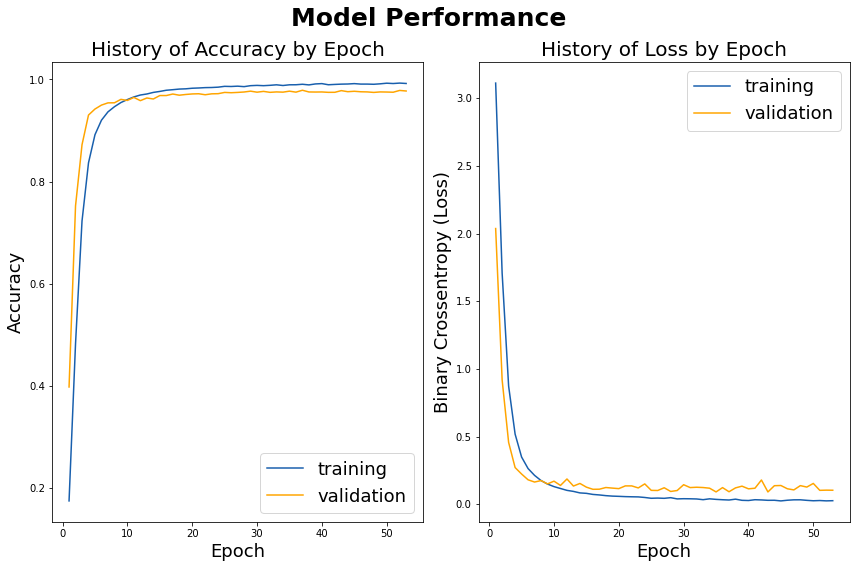

In [67]:
#run the plot for the history
Loss_Acc_Plot(history_bw.history['accuracy'],history_bw.history['val_accuracy'],
               history_bw.history['loss'],history_bw.history['val_loss'])

## Save model

If we like the results, save them. 

In [1]:
#cnn.save(name_out)

## Evalutate CNN for just GTSRB

Load our model (here is what was the "best"). Make a confusion matrix, with 0 values as nan to make the other categories stand out. Predicting a 20 kmh sign (category 0) seems to be one the default classes. Many of the dark signs that was hard to see, deafualted to 20 kmh sign. 

In [33]:
cnn_inf = load_model('../models/40_256_5_2_128_0.4_3_512_bg')

In [91]:
preds = cnn_inf.predict(test_images).round(0)
preds_recode = pd.DataFrame(preds,columns = list(range(44))).idxmax(1)
cm = confusion_matrix(test_labels['label'], preds_recode,normalize='true')

In [75]:
cm = np.where(cm == 0, np.NaN, cm)

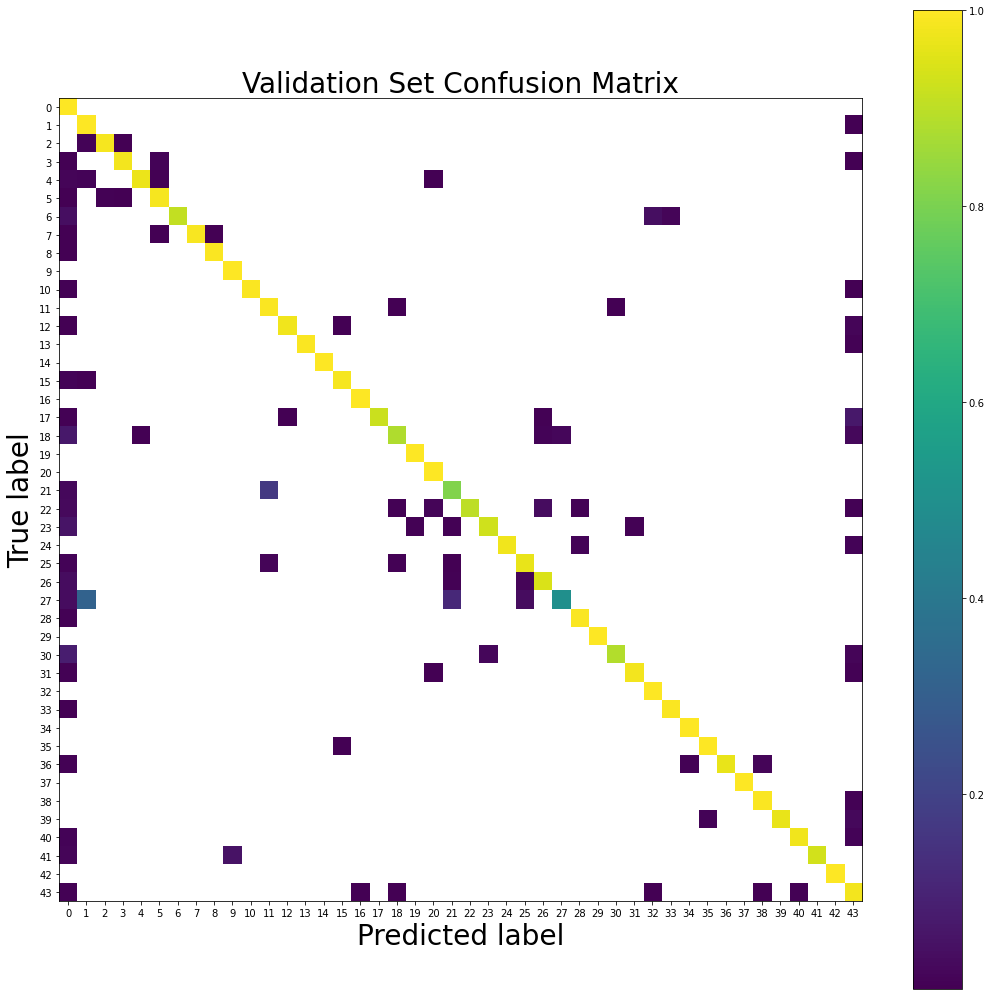

In [88]:
fig, ax = plt.subplots(figsize=(18,18))
ax.set_title('Validation Set Confusion Matrix',fontsize = 28)
ax.set_xlabel('Predicted Sign',fontsize=28)
ax.set_ylabel('True Sign',fontsize = 28)
ConfusionMatrixDisplay(cm).plot(ax=ax,include_values=False)

## Show some of the failed options

Load the sign images for comparison, and can modify second block to try and compare CNN thought process. 

In [113]:
signs = []
for i in range(43):
    signs.append(cv2.cvtColor(cv2.imread(f'GTSRB/tsr-analysis-src/resources/signs/{i}.jpg'),cv2.COLOR_BGR2RGB))

1 4


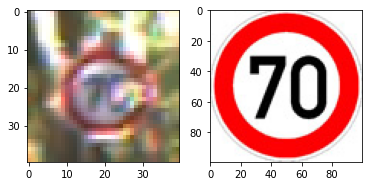

1 27


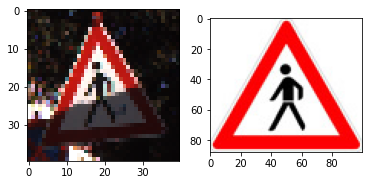

1 27


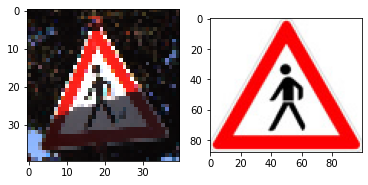

1 2


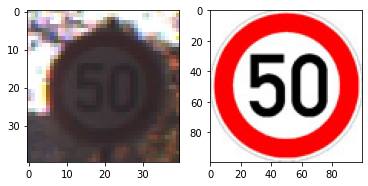

1 4


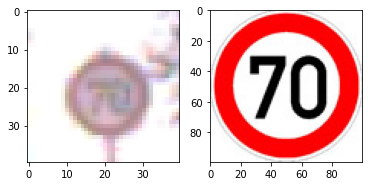

1 4


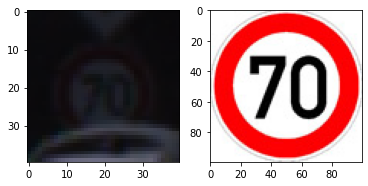

1 4


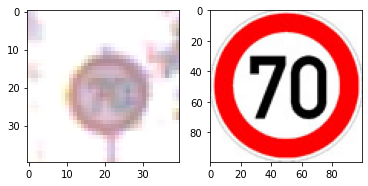

1 2


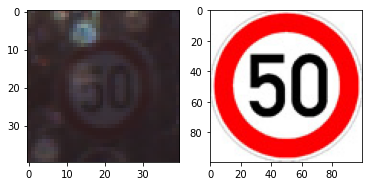

1 4


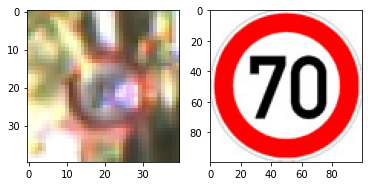

1 27


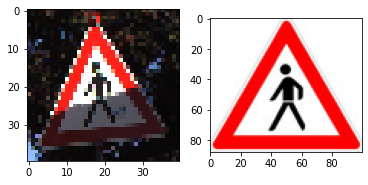

1 27


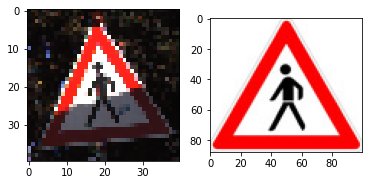

1 27


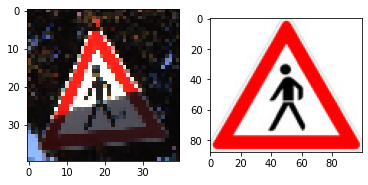

1 2


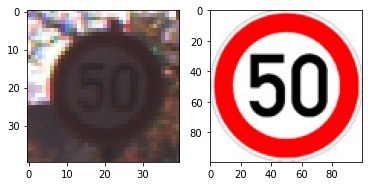

1 2


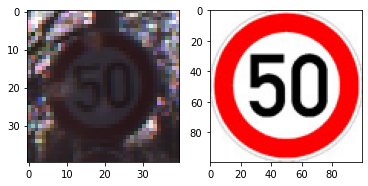

1 27


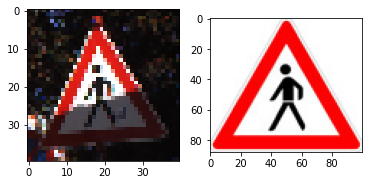

1 27


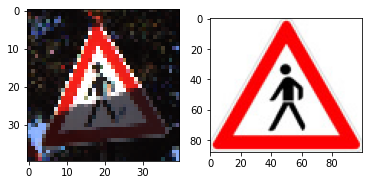

1 27


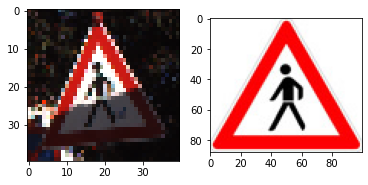

1 27


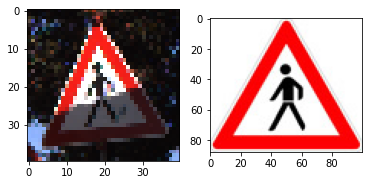

1 27


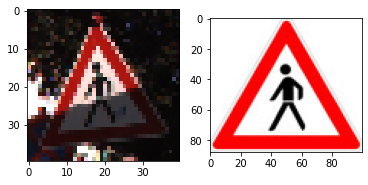

1 27


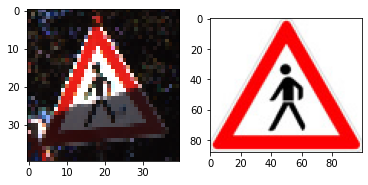

1 27


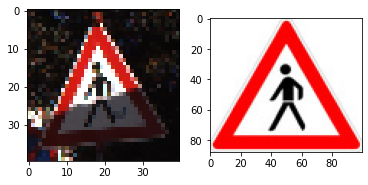

1 4


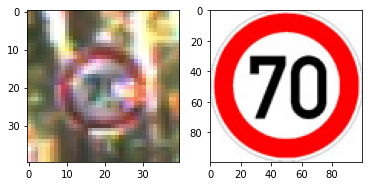

1 27


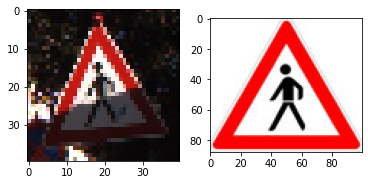

1 27


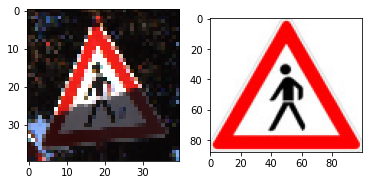

1 2


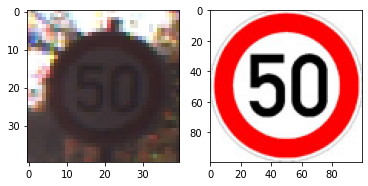

1 15


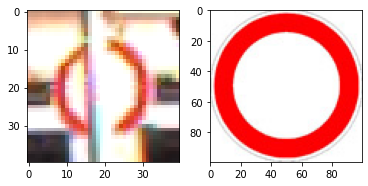

1 2


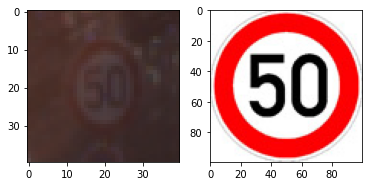

1 27


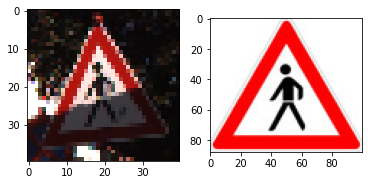

1 2


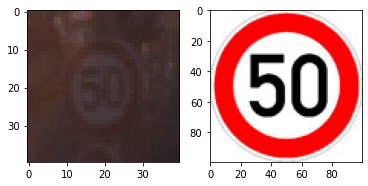

1 27


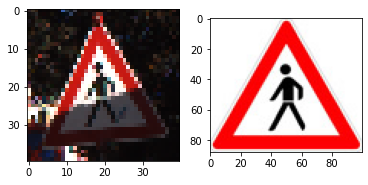

1 27


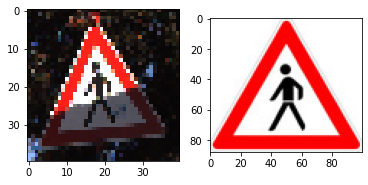

1 27


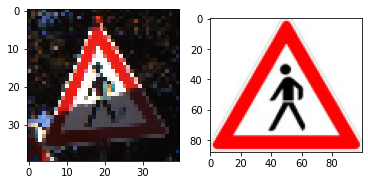

1 27


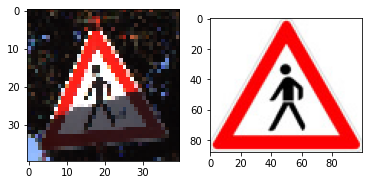

1 4


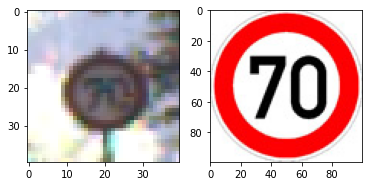

1 4


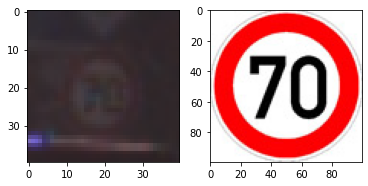

1 2


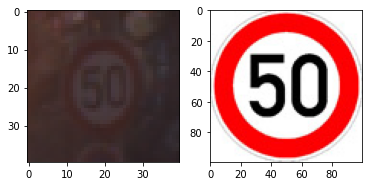

In [123]:
true_labels = test_labels['label']
for i in range(len(true_labels)):
    if true_labels[i] != preds_recode[i] & preds_recode[i] == 1:
        image = test_images[i]
        image = np.float32(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(preds_recode[i],true_labels[i])
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(signs[true_labels[i]])
        plt.show()